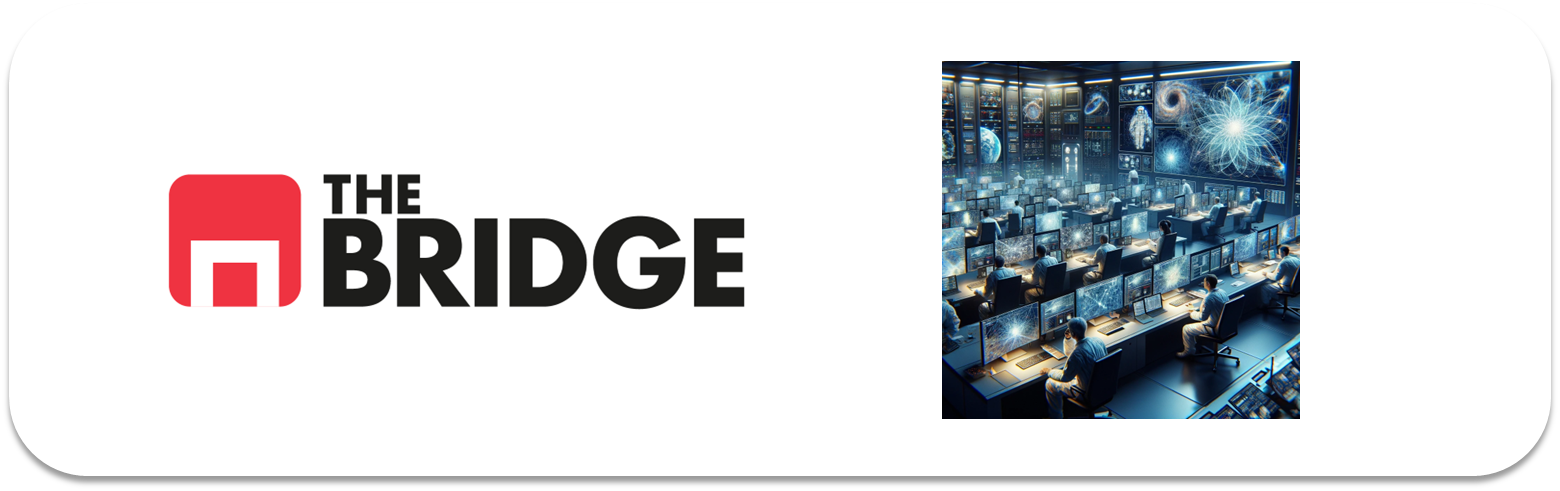

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [46]:

import seaborn as sns
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2


import warnings
#filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [47]:
ROOT_PATH = './Data/archive/'
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train"
TEST_PATH = ROOT_PATH + "seg_test/seg_test"

In [48]:
def read_data(directorio, reshape_dim = (224,224)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [49]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) 

forest
buildings
.DS_Store
glacier
street
mountain
sea
forest
buildings
.DS_Store
glacier
street
mountain
sea


In [50]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas de texto a números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded = label_encoder.fit_transform(y_train) 
y_test_encoded = label_encoder.transform(y_test)
num_clases = len(np.unique(y_train_encoded)) 

In [52]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

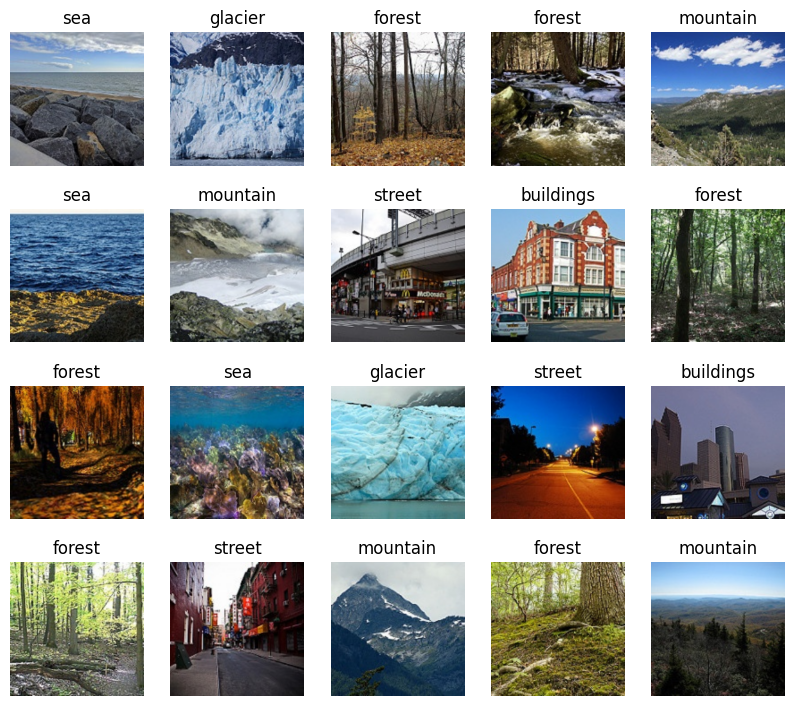

In [53]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [60]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50V2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
# Cargar el modelo VGG19 preentrenado sin la cabeza
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
vgg19_base.trainable = False

# "cabeza" del modelo
model = models.Sequential()
model.add(vgg19_base)

# Aplanar
model.add(layers.Flatten())

# Añadir capa densa oculta
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(rate= 0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(rate= 0.5))

# Capa de salida: número de clases
num_clases = 6  # Cambiar según tu conjunto de datos
model.add(layers.Dense(num_clases, activation='softmax'))

# Compilar el modelo
optimizer = Adam(learning_rate =0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,288,838 (188.02 MB)

 Trainable params: 25,724,038 (98.13 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:

# Entrenar el modelo
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [ ]:

test_loss, test_accuracy = model.evaluate(X_test, y_train_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_encoded, axis=1)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
#Cargar el modelo preentrenado y congelar sus capas
base_model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos el modelo base para el entrenamiento inicial

vgg19_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg19_base.trainable = False

model = models.Sequential()
model.add(vgg19_base) 

model.add(layers.Flatten())

# Añadir la segunda capa densa oculta
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(rate= 0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(rate= 0.5))

num_clases = 6  # Cambiar según tu conjunto de datos
model.add(layers.Dense(num_clases, activation='softmax'))

optimizer = Adam(learning_rate =0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10, batch_size=32)

for layer in base_model.layers[-4:]: 
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning
fine_tune_history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()